In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path[:]
sys.path.insert(0, '/mnt/home/landerson/src/')
sys.path.insert(0, '/mnt/home/landerson/.local/lib/python3.6/site-packages')
import pynbody
import gizmo_read
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import astropy.units as u
from astropy.constants import c, m_p, M_sun
import yt

/cm/shared/sw/pkg-old/devel/python3/3.6.2/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
from yt.units import dimensions

def _rotCoordinates(field, data):
    return get_coordinates_rotated(data, rotation_vectors=data.principal_axes_vectors)

def _rotVelocities(field, data):
    return get_coordinates_rotated(data, rotation_vectors=data.principal_axes_vectors)

yt.add_field(("all","rotCoordinates"), function=_rotCoordinates, units="auto",
             dimensions=dimensions.length)
yt.add_field(("all","rotVelocities"), function=_rotVelocities, units="auto",
             dimensions=dimensions.v)



def get_coordinates_rotated(coordinate_vectors, rotation_vectors=None, rotation_angles=None):
    '''
    Get 3-D coordinate[s] (distance or velocity vector[s]) that are rotated by input rotation
    vectors or input rotation angles.
    If rotation_vectors, need to input vectors that are orthogonal.
    If rotation_angles, rotate by rotation_angles[0] about x-axis, then by rotation_angles[1] about
    y-axis, then by rotation_angles[2] about z-axis.

    Parameters
    ----------
    coordinate_vectors : array : coordinate[s] (distance[s] or velocity[s]) wrt a center of rotation
        (object number x dimension number)
    rotation_vectors : array : *orthogonal* rotation vectors (such as max, med, min eigen-vectors)
    rotation_angles : array : rotation angles about x-axis, y-axis, z-axis [radians]

    Returns
    -------
    coordinate[s] (distance[s] or velocity[s]) in rotated basis :
        array (object number x dimension number)
    '''
    if rotation_vectors is not None:
        # sanity check - ensure input rotation vectors are orthogonal
        tolerance = 1e-6
        if (np.abs(np.dot(rotation_vectors[0], rotation_vectors[1])) > tolerance or
                np.abs(np.dot(rotation_vectors[0], rotation_vectors[2])) > tolerance or
                np.abs(np.dot(rotation_vectors[1], rotation_vectors[2])) > tolerance):
            raise ValueError('input rotation_vectors are not orthogonal')

    elif rotation_angles is not None:
        m11 = np.cos(rotation_angles[1]) * np.cos(rotation_angles[2])
        m12 = (np.cos(rotation_angles[0]) * np.sin(rotation_angles[2]) +
               np.sin(rotation_angles[0]) * np.sin(rotation_angles[1]) * np.cos(rotation_angles[2]))
        m13 = (np.sin(rotation_angles[0]) * np.sin(rotation_angles[2]) -
               np.cos(rotation_angles[0]) * np.sin(rotation_angles[1]) * np.cos(rotation_angles[2]))
        m21 = -np.cos(rotation_angles[1]) * np.sin(rotation_angles[2])
        m22 = (np.cos(rotation_angles[0]) * np.cos(rotation_angles[2]) -
               np.sin(rotation_angles[0]) * np.sin(rotation_angles[1]) * np.sin(rotation_angles[2]))
        m23 = (np.sin(rotation_angles[0]) * np.cos(rotation_angles[2]) +
               np.cos(rotation_angles[0]) * np.sin(rotation_angles[1]) * np.sin(rotation_angles[2]))
        m31 = np.sin(rotation_angles[1])
        m32 = -np.sin(rotation_angles[0]) * np.cos(rotation_angles[1])
        m33 = np.cos(rotation_angles[0]) * np.cos(rotation_angles[1])

        rotation_vectors = np.array([
            [m11, m12, m13],
            [m21, m22, m23],
            [m31, m32, m33]],
            dtype=coordinate_vectors.dtype
        )

    else:
        raise ValueError('need to input either rotation angles or rotation vectors')

    # have to do this way
    coordinate_vectors_rotated = np.asarray(
        np.dot(coordinate_vectors, rotation_vectors.transpose()), dtype=coordinate_vectors.dtype)

    return coordinate_vectors_rotated


/cm/shared/sw/pkg-old/devel/python3/3.6.2/lib/python3.6/site-packages/yt/fields/local_fields.py:46: UserWarning: Because 'sampling_type' not specified, yt will assume a cell 'sampling_type'
  warnings.warn("Because 'sampling_type' not specified, yt will "


In [5]:
simname = 'm12f'

In [6]:
directory = '/mnt/ceph/users/firesims/ananke/Latte/' + simname + '/'

In [7]:
filename = '/mnt/ceph/users/firesims/ananke/Latte/' + simname + '/snapdir_600/snapshot_600.0.hdf5'
ds = yt.load(filename)
ad = ds.all_data()

yt : [INFO     ] 2019-03-22 11:48:53,330 Calculating time from 1.000e+00 to be 4.355e+17 seconds
yt : [INFO     ] 2019-03-22 11:48:53,332 Assuming length units are in kpc/h (comoving)
yt : [INFO     ] 2019-03-22 11:48:53,353 Parameters: current_time              = 4.3545571088051386e+17 s
yt : [INFO     ] 2019-03-22 11:48:53,355 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2019-03-22 11:48:53,356 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2019-03-22 11:48:53,357 Parameters: domain_right_edge         = [60000. 60000. 60000.]
yt : [INFO     ] 2019-03-22 11:48:53,359 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2019-03-22 11:48:53,360 Parameters: current_redshift          = 0.0
yt : [INFO     ] 2019-03-22 11:48:53,361 Parameters: omega_lambda              = 0.728
yt : [INFO     ] 2019-03-22 11:48:53,362 Parameters: omega_matter              = 0.272
yt : [INFO     ] 2019-03-22 11:48:53,364 Parameters: hubble_constant           = 0.

In [8]:
part = gizmo_read.read.Read.read_snapshot(species='all', 
                                          properties= 'all', 
                                          directory=directory)

reading header from:
  /mnt/ceph/users/firesims/ananke/Latte/m12f/snapdir_600/snapshot_600.0.hdf5

snapshot contains the following number of particles:
  dark   (id = 1): 96239056 particles
  dark.2 (id = 2): 7591203 particles
  gas    (id = 0): 80307825 particles
  star   (id = 4): 16066489 particles

reading dark properties:
  ['id', 'mass', 'position', 'potential', 'velocity']
reading dark.2 properties:
  ['id', 'mass', 'position', 'potential', 'velocity']
reading gas properties:
  ['density', 'electron.fraction', 'hydrogen.neutral.fraction', 'id', 'mass', 'massfraction', 'position', 'potential', 'temperature', 'velocity']
reading star properties:
  ['form.scalefactor', 'id', 'mass', 'massfraction', 'position', 'potential', 'velocity']

reading particles from:
  snapshot_600.0.hdf5
  snapshot_600.1.hdf5
  snapshot_600.2.hdf5
  snapshot_600.3.hdf5

reading galaxy center coordinates and principal axes from:  mnt/ceph/users/firesims/ananke/Latte/m12f/m12f_res7100_center.txt
  center po

In [9]:
gizmo_read.read.Read.read_lsr_coordinates(part, directory=directory, lsr_index=2)
for key in part.keys():
    part[key]['position'] = part[key]['position'] - part.lsr_position
    part[key]['velocity'] = part[key]['velocity'] - part.lsr_velocity


reading LSR coordinates from:
  mnt/ceph/users/firesims/ananke/Latte/m12f/m12f_res7100_LSR2.txt
  LSR_2 position [kpc] = 7.101, -4.100, 0.000
  LSR_2 velocity [km/s] = -118.1, -187.8, -3.9



In [10]:
print(part.center_position, part.center_velocity, part.principal_axes_vectors)

[38711.76113 47665.07165 46817.26477] [-154.47322  160.85855  106.8271 ] [[-4.64385979e-01  2.91482979e-01  8.36291418e-01]
 [ 7.08714933e-01 -4.43966940e-01  5.48285053e-01]
 [ 5.31101502e-01  8.47308108e-01 -4.06318212e-04]]


In [29]:
ad.set_field_parameter?

Signature: ad.set_field_parameter(name, val)
Docstring:
Here we set up dictionaries that get passed up and down and ultimately
to derived fields.
File:      /cm/shared/sw/pkg-old/devel/python3/3.6.2/lib/python3.6/site-packages/yt/data_objects/data_containers.py
Type:      method


In [11]:
ad.set_field_parameter('center', part.center_position)
ad.set_field_parameter('bulk velocity', part.center_velocity)

In [12]:
ad[('all', 'rotCoordinates')]

yt : [INFO     ] 2019-03-22 11:57:58,465 Allocating for 2.002e+08 particles (index particle type 'all')
yt : [INFO     ] 2019-03-22 11:58:47,275 Identified 1.257e+07 octs


AttributeError: 'FieldDetector' object has no attribute 'principal_axes_vectors'

In [28]:
ds.unit_registry.keys()

dict_keys(['g', 's', 'K', 'radian', 'dyne', 'erg', 'esu', 'gauss', 'degC', 'statA', 'statV', 'statohm', 'm', 'J', 'W', 'Hz', 'N', 'C', 'A', 'T', 'Pa', 'V', 'ohm', 'ft', 'mile', 'degF', 'R', 'lbf', 'lbm', 'atm', 'h', 'dimensionless', 'min', 'hr', 'day', 'yr', 'c', 'Msun', 'msun', 'Rsun', 'rsun', 'R_sun', 'r_sun', 'Lsun', 'Tsun', 'Zsun', 'Mjup', 'Mearth', 'AU', 'au', 'ly', 'pc', 'degree', 'arcmin', 'arcsec', 'mas', 'hourangle', 'steradian', 'lat', 'lon', 'eV', 'amu', 'angstrom', 'Jy', 'counts', 'photons', 'me', 'mp', 'mol', 'Sv', 'rayleigh', 'solMass', 'solRad', 'solLum', 'dyn', 'sr', 'rad', 'deg', 'Fr', 'G', 'd', 'Angstrom', 'statC', 'm_pl', 'l_pl', 't_pl', 'T_pl', 'q_pl', 'E_pl', 'm_geom', 'l_geom', 't_geom', 'R_earth', 'r_earth', 'R_jup', 'r_jup', 'code_length', 'code_mass', 'code_density', 'code_time', 'code_magnetic', 'code_temperature', 'code_pressure', 'code_velocity', 'code_metallicity', 'a', 'mcm', 'pccm', 'AUcm', 'aucm', 'kpccm', 'cm', 'kmcm', 'unitary', 'keV'])

In [22]:
ad[('PartType0', 'Coordinates')]

YTArray([[27139.21645042, 33484.46890911, 32859.658069  ],
         [27138.93735779, 33484.61865698, 32859.30146507],
         [27138.98488175, 33484.87376245, 32859.75935517],
         ...,
         [26726.81694266, 31046.06349684, 33119.72474516],
         [26727.62432397, 31045.72253857, 33113.68700899],
         [26721.38784047, 31053.77053939, 33110.44325612]]) code_length

In [23]:
part['gas']['position']

array([[ 1.95772373e+01, -5.23410718e+01,  9.06008988e-01],
       [ 1.93992186e+01, -5.29960587e+01,  8.75810943e-01],
       [ 2.00191887e+01, -5.27517897e+01,  1.21941055e+00],
       ...,
       [-4.10265491e+02,  1.27655974e+03, -3.25438223e+03],
       [-4.18133906e+02,  1.27287481e+03, -3.25417944e+03],
       [-4.14530960e+02,  1.25895538e+03, -3.24918194e+03]])

In [14]:
gizmo_read.read.Read.read_galaxy_center_coordinates?

Signature: gizmo_read.read.Read.read_galaxy_center_coordinates(part, directory='.')
Docstring:
Read pre-computed galaxy center position and velocity,
as well as principal axes rotation vectors.
Generally, this should be a file named:  m12*_res7100_center.txt
Append to particle catalog dictionary class.

Parameters
----------
part : dictionary class : catalog of particles at snapshot
directory : string : directory of file
File:      ~/src/gizmo_read/read.py
Type:      method


In [12]:
ds.add_field?

Signature: ds.add_field(name, function=None, sampling_type=None, **kwargs)
Docstring:
Dataset-specific call to add_field

Add a new field, along with supplemental metadata, to the list of
available fields.  This respects a number of arguments, all of which
are passed on to the constructor for
:class:`~yt.data_objects.api.DerivedField`.

Parameters
----------

name : str
   is the name of the field.
function : callable
   A function handle that defines the field.  Should accept
   arguments (field, data)
units : str
   A plain text string encoding the unit.  Powers must be in
   python syntax (** instead of ^).
take_log : bool
   Describes whether the field should be logged
validators : list
   A list of :class:`FieldValidator` objects
particle_type : bool
   Is this a particle (1D) field?
vector_field : bool
   Describes the dimensionality of the field.  Currently unused.
display_name : str
   A name used in the plots
force_override : bool
   Whether to override an existing derived fie

In [ ]:
positions = ad['all', 'Coordinates']  - part.lsr_position
velocities = ad['all', 'Velocities'] - part.lsr_velocity

In [ ]:
#density ==> rho, smooth.length ==> smooth, mass ==> mass 
sim.gas['pos'] = pynbody.array.SimArray(positions)
sim.gas['pos'].units = 'kpc'

sim.gas['vel'] = pynbody.array.SimArray(velocities)
sim.gas['vel'].units = 'km s^-1'

sim.gas['eps'] = sim.gas['smooth']
sim.gas['eps'].units = 'kpc'


sim.gas['massfraction.all'] = part['gas']['massfraction'][:,0]
sim.gas['massfraction.all'].units = '1'
sim.gas['massfraction.he']  = part['gas']['massfraction'][:,1]
sim.gas['massfraction.he'].units = '1'

sim.gas['massfraction.all.relativesolar'] = 10.**part['gas']['metallicity.total']
sim.gas['massfraction.all.relativesolar'].units = '1'

for key in ['hydrogen.neutral.fraction']:
    sim.gas[key] = pynbody.array.SimArray(part['gas'][key])
    sim.gas[key].units = '1'


In [ ]:
sim.gas['smooth']

In [ ]:
solarMetallicity = 0.2
fractionHydrogen = 1 - sim.gas['massfraction.he'] - sim.gas['massfraction.all']
neutralHydrogenMass = sim.gas['mass']*(fractionHydrogen)*sim.gas['hydrogen.neutral.fraction']
metalWeightedNeutralHydrogenMass = neutralHydrogenMass*sim.gas['massfraction.all.relativesolar']

In [ ]:
metalWeightedNeutralHydrogenMass

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].hist(np.log10(fractionHydrogen*sim.gas['hydrogen.neutral.fraction']*sim.gas['massfraction.all.relativesolar']), 
           range = [-10, 1], bins=100, log=True, histtype='step')
ax[0].set_title('Metal Weighted Neutral Hydorgen Fraction')
ax[0].set_xlabel('Metal Weighted Neutral Hydorgen Fraction')

ax[1].hist(np.log10(neutralHydrogenMass), bins=100, log=True, range = [-5, 1], histtype='step')
ax[1].set_title('Neutral Hydrogen Mass')
ax[1].set_xlabel('Neutral Hydrogen Mass [Msol]')

ax[2].hist(np.log10(metalWeightedNeutralHydrogenMass), bins=100, log=True, range = [-5, 1], histtype='step')
ax[2].set_title('Metal Weighted Neutral Hydrogen Mass')
ax[2].set_xlabel('Metal Weighted Neutral Hydrogen Mass [Msol]')


In [ ]:
sim.gas['metalWeightedNeutralHydrogenMass'] = pynbody.array.SimArray(metalWeightedNeutralHydrogenMass.in_units('Msol'))
sim.gas['metalWeightedNeutralHydrogenMass'].units = 'Msol'

sim.gas['neutralHydrogenMass'] = pynbody.array.SimArray(neutralHydrogenMass.in_units('Msol'))
sim.gas['neutralHydrogenMass'].units = 'Msol'

sim.gas['metalWeightedNeutralHydrogenNumber'] = pynbody.array.SimArray(metalWeightedNeutralHydrogenMass.in_units('kg'), 
                                                                       dtype='float64')/m_p.to('kg')
sim.gas['metalWeightedNeutralHydrogenNumber'].units = '1'

In [ ]:
sim.gas['metalWeightedNeutralHydrogenNumber']

In [ ]:
sim.gas['metalWeightedNeutralHydrogenMass']

In [ ]:
sim.gas.keys()

In [ ]:
for k in sim.gas.keys(): print(k, sim.gas[k].dtype)

In [ ]:
for key in ['smooth', 'mass', 'metalWeightedNeutralHydrogenMass', 'eps', 'rho']:
    arr = np.asanyarray(sim.gas[key], dtype=sim.gas['pos'].dtype)
    del sim.gas[key]
    sim.gas[key]= arr

In [ ]:
x1 = "-750 pc"
x2 = "750 pc"
y1 = "-750 pc"
y2 = "750 pc"
z1 = "-750 pc"
z2 = "750 pc"
box = pynbody.filt.Cuboid(x1, y1=y1, z1=z1, x2=x2, y2=y2, z2=z2)

im = pynbody.sph.to_3d_grid(sim[box].gas, qty='rho', nx=15, ny=15, nz=15, threaded=False, approximate_fast=False)


In [ ]:
scale = '0.5 kpc'

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
pynbody.plot.image(sim.gas, qty='rho', width = '100 kpc', 
                   subplot=ax[0], show_cbar=False, title='Gas Density')
pynbody.plot.image(sim.gas, qty='metalWeightedNeutralHydrogenMass', width = '100 kpc', 
                   subplot=ax[1], show_cbar=False, title='Metal Weighted')
plt.tight_layout()
plt.savefig('m12flsr2faceon.pdf', rasterized=True)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
pynbody.plot.image(sim.gas, qty='rho', width = scale, 
                   subplot=ax[0], show_cbar=False, title='gas density')
pynbody.plot.image(sim.gas, qty='metalWeightedNeutralHydrogenMass', width = scale, 
                   subplot=ax[1], show_cbar=False, title='Metal Weighted')
plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sim.gas.rotate_x(90)
pynbody.plot.image(sim.gas, qty='rho', width = '100 kpc', 
                   subplot=ax[0], show_cbar=False, title='Gas Density')
pynbody.plot.image(sim.gas, qty='metalWeightedNeutralHydrogenMass', width = '100 kpc', 
                   subplot=ax[1], show_cbar=False, title='Metal Weighted')
sim.gas.rotate_x(-90)
plt.tight_layout()
plt.savefig('m12flsr2sideone.pdf', rasterized=True)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sim.gas.rotate_x(90)
pynbody.plot.image(sim.gas, qty='rho', width = scale, 
                   subplot=ax[0], show_cbar=False, title='gas density')
pynbody.plot.image(sim.gas, qty='metalWeightedNeutralHydrogenMass', width = scale, 
                   subplot=ax[1], show_cbar=False, title='Metal Weighted')
sim.gas.rotate_x(-90)
plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sim.gas.rotate_y(90)
pynbody.plot.image(sim.gas, qty='rho', width = '100 kpc', 
                   subplot=ax[0], show_cbar=False, title='Gas Density')
pynbody.plot.image(sim.gas, qty='metalWeightedNeutralHydrogenMass', width = '100 kpc', 
                   subplot=ax[1], show_cbar=False, title='Metal Weighted')
sim.gas.rotate_y(-90)
plt.tight_layout()
plt.savefig('m12flsr2sideon2.pdf', rasterized=True)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sim.gas.rotate_y(90)
pynbody.plot.image(sim.gas, qty='rho', width = scale, 
                   subplot=ax[0], show_cbar=False, title='Neutral Hydrogen')
pynbody.plot.image(sim.gas, qty='metalWeightedNeutralHydrogenMass', width = scale, 
                   subplot=ax[1], show_cbar=False, title='Metal Weighted')
sim.gas.rotate_y(-90)
plt.tight_layout()

In [ ]:
np.linspace(-400, 400.0001, 5)

In [ ]:
x1 = "-10 kpc"
x2 = "10 kpc"
y1 = "-10 kpc"
y2 = "10 kpc"
zup = np.linspace(-1000, 1000.0001, 10)[1:]
zdown = np.linspace(-1000, 1000.0001, 10)[:-1]

for i, (zu, zd) in enumerate(zip(zup, zdown)):
        
    box = pynbody.filt.Cuboid(x1, y1=y1, z1=str(zd) + ' pc', x2=x2, y2=y2, z2=str(zu) + ' pc')
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    im = pynbody.plot.image(sim[box].gas, qty='rho', width = scale, 
                   subplot=ax[0], show_cbar=False, title='rho z {0:.1f} - {1:.1f} pc'.format(zu, zd))

    im = pynbody.plot.image(sim[box].gas, qty='metalWeightedNeutralHydrogenMass', width =  scale, 
                   subplot=ax[1], show_cbar=True, title='Metal Weighted', vmax=1e4, vmin=1e2)

    plt.tight_layout()
    fig.savefig('anankedust{0}.pdf'.format(i), rasterized=True)

In [40]:
radius = "2 kpc" # or might be a float if you already know your units
centre = (0,0,0) # Take the origin for now
sphere = pynbody.filt.Sphere(radius, centre)

In [50]:
sim[sphere].gas

<SimSnap "/mnt/ceph/users/firesims/ananke/Latte/m12f/snapdir_600/snapshot_600:sphere::gas" len=10575>

In [47]:
pynbody.sph.to_3d_grid?

Signature: pynbody.sph.to_3d_grid(snap, qty='rho', nx=None, ny=None, nz=None, x2=None, out_units=None, xy_units=None, kernel=<pynbody.sph.Kernel object at 0x2aab20e8add8>, smooth='smooth', approximate_fast=True, threaded=None, snap_slice=None, denoise=None)
Docstring:
Project SPH onto a grid using a typical (mass/rho)-weighted 'scatter'
scheme.

**Keyword arguments:**

*qty* ('rho'): The name of the array within the simulation to render

*nx* (x2-x1 / soft): The number of pixels wide to make the grid

*ny* (nx): The number of pixels tall to make the grid

*nz* (nx): The number of pixels deep to make the grid

*out_units* (no conversion): The units to convert the output grid into

*xy_units*: The units for the x and y axes

*kernel*: The Kernel object to use (default Kernel(), a 3D spline kernel)

*smooth*: The name of the array which contains the smoothing lengths
  (default 'smooth')

*denoise*: if True, divide through by an estimate of the discreteness noise.
  The returned image is 

In [34]:
pynbody.__version__

'0.46'

In [36]:
x1 = "-750 pc"
x2 = "750 pc"
y1 = "-750 pc"
y2 = "750 pc"
z1 = "-750 pc"
z2 = "750 pc"
box = pynbody.filt.Cuboid(x1, y1=y1, z1=z1, x2=x2, y2=y2, z2=z2)

im = pynbody.sph.to_3d_grid(sim[box].gas, qty='mass', nx=15, ny=15, nz=15, threaded=False, approximate_fast=False)


TypeError: No matching signature found

In [44]:
H0 = sim.gas['smooth']
m0 = sim.gas['mass']
z0 = part['gas']['metallicity.total']
#z0 = sim.gas['metallicity.total']
yHe = part['gas']['metallicity.he']
#yHe = sim.gas['metallicity.he']
fH = 1 - yHe - z0
fneutral = part['gas']['hydrogen.neutral.fraction']
#fneutral = sim.gas['hydrogen.neutral.fraction']
fH_0 = fH*fneutral
hubble = sim.properties['h']
Hmin = 0.25*0.0131968*hubble
H0 = np.sqrt(H0*H0 + Hmin*Hmin)
z0 = np.sqrt(z0*z0 + 1e-5*1e-5)
wt = fH_0*m0*(z0/0.2)/(H0 * H0 * H0) #*hubble took out, but need to check

In [38]:
fH_0*z0/0.2

SimArray([3.0117901e-03, 1.9458423e-05, 2.1456985e-06, ..., 3.1745850e-04,
          2.8330507e-04, 2.6646798e-04], dtype=float32)

In [79]:
numberH = pynbody.array.SimArray(m0.in_units('kg'), dtype='float64')*fH_0*z0/0.2/m_p.value

In [80]:
numberH.sim = sim # this links the array to the simulation

numberH.units = '1'

In [81]:
numberH

SimArray([2.80229182e+58, 1.63800227e+56, 1.84048903e+55, ...,
          2.66783288e+57, 2.38081691e+57, 2.23932283e+57], '1.00e+00')

In [ ]:
pynbody.sph.to_3d_grid(sim.gas, qty=)

In [9]:
radius = np.sqrt(np.sum(part['gas']['position']**2, axis=1))

In [10]:
smoothlength = (part['gas']['mass']/part['gas']['density'])**(1/3)

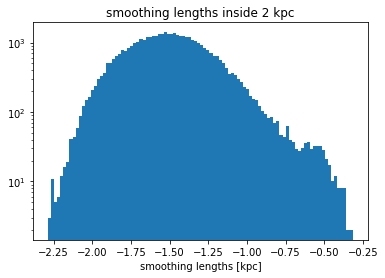

In [53]:
plt.hist(np.log10(smoothlength[radius < 2]), log=True, bins=100)
plt.xlabel('smoothing lengths [kpc]')
plt.title('smoothing lengths inside 2 kpc')

In [48]:
xbins = np.linspace(0, 100, 100)
ybins = np.linspace(0, 2.5, 100)
H, xe, ye = np.histogram2d(radius, smoothlength, bins=[xbins,ybins])

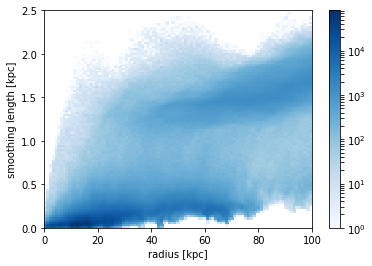

In [49]:
im = plt.pcolormesh(xe, ye, H.T,
  norm=mpl.colors.LogNorm(), cmap=plt.get_cmap('Blues'))#vmax=75))#, vmax=20) #, vmin=-100, vmax=100)
im.set_rasterized(True)
plt.xlabel('radius [kpc]')
plt.ylabel('smoothing length [kpc]')
plt.colorbar()
plt.savefig('smoothinglengths.pdf')


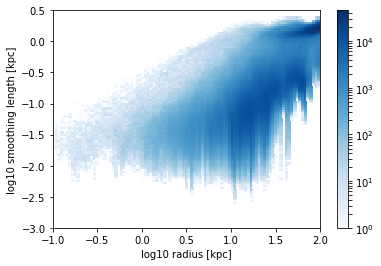

In [45]:
xbins = np.linspace(-1, 2, 100)
ybins = np.linspace(-3, 0.5, 100)
H, xe, ye = np.histogram2d(np.log10(radius), np.log10(smoothlength), bins=[xbins,ybins])
im = plt.pcolormesh(xe, ye, H.T,
  norm=mpl.colors.LogNorm(), cmap=plt.get_cmap('Blues'))#vmax=75))#, vmax=20) #, vmin=-100, vmax=100)
im.set_rasterized(True)
plt.xlabel('log10 radius [kpc]')
plt.ylabel('log10 smoothing length [kpc]')
plt.colorbar()
plt.savefig('smoothinglengths_logspace.pdf')

In [8]:
part['gas'].keys()

dict_keys(['position', 'density', 'mass', 'massfraction', 'hydrogen.neutral.fraction', 'velocity', 'metallicity.total', 'metallicity.he', 'metallicity.c', 'metallicity.n', 'metallicity.o', 'metallicity.ne', 'metallicity.mg', 'metallicity.si', 'metallicity.s', 'metallicity.ca', 'metallicity.fe'])

In [56]:
part.info['hubble']

0.702

In [57]:

H0 = smoothlength
m0 = part['gas']['mass']
z0 = part['gas']['metallicity.total']
yHe = part['gas']['metallicity.he']
fH = 1 - yHe - z0
fneutral = part['gas']['hydrogen.neutral.fraction']
fH_0 = fH*fneutral
hubble = part.info['hubble']
Hmin = 0.25*0.0131968*hubble
H0 = np.sqrt(H0*H0 + Hmin*Hmin)
z0 = np.sqrt(z0*z0 + 1e-5*1e-5)
wt = fH_0*m0*(z0/0.2)*hubble*2.08854/(H0 * H0 * H0)*6.7702543e-32

In [58]:
wt

array([2.7916403e-29, 6.0049988e-32, 5.1357469e-33, ..., 1.1868977e-34,
       9.8885191e-35, 8.5286609e-35], dtype=float32)

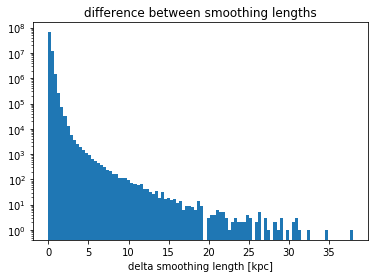

In [139]:
plt.hist(smoothlength*2. - sim.gas['smooth'], bins=100, log=True)
plt.title('difference between smoothing lengths')
plt.xlabel('delta smoothing length [kpc]')

In [96]:
smoothlength*2.

array([ 0.87517923,  1.2212816 ,  1.3375983 , ..., 24.667978  ,
       25.239653  , 25.979477  ], dtype=float32)

In [94]:
sim.gas['smooth']

SimArray([ 0.8604047,  1.2018559,  1.3172091, ..., 24.284779 , 24.854115 ,
          25.59525  ], dtype=float32, 'kpc')

In [5]:
sim.properties

{'CompactLevel': 0,
 'Compactify_Version': 'v0.2',
 'Flag_Cooling': 1,
 'Flag_DoublePrecision': 0,
 'Flag_Feedback': 1,
 'Flag_IC_Info': 3,
 'Flag_Metals': 15,
 'Flag_Sfr': 1,
 'Flag_StellarAge': 1,
 'MassTable': array([0., 0., 0., 0., 0., 0.]),
 'NumFilesPerSnapshot': 8,
 'NumPart_ThisFile': array([12287337, 15681167,  1156375,        0,  2907365,        0],
       dtype=int32),
 'NumPart_Total': array([116752958, 140876456,  10063684,         0,  25344979,         0],
       dtype=uint32),
 'NumPart_Total_HighWord': array([0, 0, 0, 0, 0, 0], dtype=uint32),
 'ReadMe': 'This snapshot is part of the Feedback in Realistic Environments (FIRE) project -- Use, modification, or distribution only permitted with approval of the PI and the FIRE team -- No warranty, use at your own risk -- compactify_hdf5 (c) RF 2018',
 'Redshift': 0.0,
 'a': 1.0,
 'boxsize': Unit("6.00e+04 kpc a h**-1"),
 'h': 0.702,
 'omegaL0': 0.728,
 'omegaM0': 0.272,
 'time': Unit("1.38e+01 Gyr")}

In [140]:
part.info

{'box.length': 85470.08547008547,
 'box.length/h': 60000.0,
 'compression.level': 0,
 'compression.readme': 'This snapshot is part of the Feedback in Realistic Environments (FIRE) project -- Use, modification, or distribution only permitted with approval of the PI and the FIRE team -- No warranty, use at your own risk -- compactify_hdf5 (c) RF 2018',
 'compression.version': 'v0.2',
 'file.number.per.snapshot': 4,
 'has.cooling': 1,
 'has.double.precision': 0,
 'has.feedback': 1,
 'has.ic.info': 3,
 'has.metals': 11,
 'has.star.age': 1,
 'has.star.formation': 1,
 'hubble': 0.702,
 'omega_lambda': 0.728,
 'omega_matter': 0.272,
 'particle.masses': array([0., 0., 0., 0., 0., 0.]),
 'particle.numbers.in.file': array([17469196, 22580726,  1143988,        0,  3530159,        0],
       dtype=int32),
 'particle.numbers.total': array([80307825, 96239056,  7591203,        0, 16066489,        0],
       dtype=uint32),
 'particle.numbers.total.high.word': array([0, 0, 0, 0, 0, 0], dtype=uint32),


In [24]:
pynbody.plot.image(sim.gas, qty='rho', threaded=False)

SimArray([[ 23608.521,  23651.838,  23695.154, ..., 341265.94 ,
           345980.12 , 350694.3  ],
          [ 23579.764,  23622.121,  23664.479, ..., 341088.44 ,
           345823.94 , 350559.44 ],
          [ 23551.008,  23592.404,  23633.803, ..., 340910.9  ,
           345667.75 , 350424.6  ],
          ...,
          [ 75173.555,  75946.77 ,  76719.99 , ...,  14089.778,
            14087.451,  14085.125],
          [ 74193.266,  74967.34 ,  75741.414, ...,  14074.972,
            14073.712,  14072.452],
          [ 73212.984,  73987.914,  74762.836, ...,  14060.165,
            14059.972,  14059.778]], dtype=float32, 'Msol kpc**-3')

In [28]:
pynbody.plot.image?

Signature: pynbody.plot.image(sim, qty='rho', width='10 kpc', resolution=500, units=None, log=True, vmin=None, vmax=None, av_z=False, filename=None, z_camera=None, clear=True, cmap=None, title=None, qtytitle=None, show_cbar=True, subplot=False, noplot=False, ret_im=False, fill_nan=True, fill_val=0.0, linthresh=None, **kwargs)
Docstring:
Make an SPH image of the given simulation.

**Keyword arguments:**

*qty* (rho): The name of the array to interpolate

*width* (10 kpc): The overall width and height of the plot. If
 ``width`` is a float or an int, then it is assumed to be in units
 of ``sim['pos']``. It can also be passed in as a string
 indicating the units, i.e. '10 kpc', in which case it is
 converted to units of ``sim['pos']``.

*resolution* (500): The number of pixels wide and tall

*units* (None): The units of the output

*av_z* (False): If True, the requested quantity is averaged down
        the line of sight (default False: image is generated in
        the thin plane z=0, unl

SimArray([[ 424477.2  ,  393189.97 ,  361902.62 , ...,  126312.484,
            132657.23 ,  139002.   ],
          [ 503328.75 ,  455369.97 ,  407411.1  , ...,  119717.73 ,
            125042.   ,  130366.26 ],
          [ 582180.44 ,  517549.9  ,  452919.53 , ...,  113122.97 ,
            117426.76 ,  121730.555],
          ...,
          [5566025.5  , 5480298.5  , 5394572.   , ...,  862430.4  ,
            930834.94 ,  999239.2  ],
          [4943844.   , 4899355.   , 4854867.5  , ...,  782047.8  ,
            844457.5  ,  906867.2  ],
          [4321662.5  , 4318412.5  , 4315163.5  , ...,  701665.4  ,
            758080.3  ,  814495.06 ]], dtype=float32, 'Msol kpc**-3')

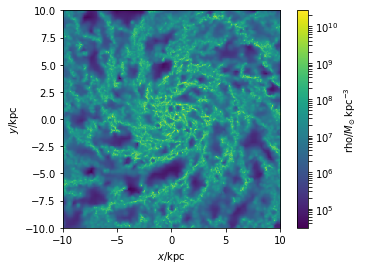

SimArray([[17295.158, 17297.473, 17299.79 , ..., 15341.798, 15295.941,
           15250.077],
          [17306.752, 17308.922, 17311.09 , ..., 15515.022, 15467.895,
           15420.77 ],
          [17318.348, 17320.371, 17322.389, ..., 15688.247, 15639.854,
           15591.461],
          ...,
          [45054.527, 45579.07 , 46103.625, ..., 19413.475, 19394.088,
           19374.7  ],
          [44618.38 , 45133.63 , 45648.875, ..., 19219.459, 19196.738,
           19174.02 ],
          [44182.234, 44688.184, 45194.125, ..., 19025.451, 18999.389,
           18973.334]], dtype=float32, 'Msol kpc**-3')

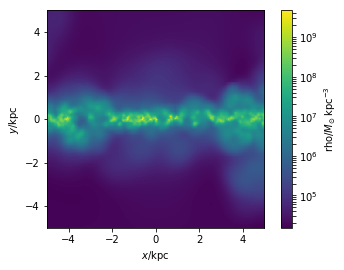

In [27]:
pynbody.plot.sideon_image(sim.gas)

In [12]:
sim.all_keys()

['u',
 'p',
 'HII',
 'HeIII',
 'ne',
 'rho_ne',
 'dm',
 'cosmodm',
 'redshift',
 'doppler_redshift',
 'em',
 'halpha',
 'c_n_sq',
 'hetot',
 'hydrogen',
 'HI',
 'HIeos',
 'HID12',
 'HeI',
 'HeII',
 'OI',
 'OII',
 'OVI',
 'CIV',
 'NV',
 'SIV',
 'MGII',
 'feh',
 'sixh',
 'sxh',
 'mgxh',
 'oxh',
 'nexh',
 'cxh',
 'caxh',
 'nxh',
 'ofe',
 'mgfe',
 'nefe',
 'sife',
 'smooth',
 'rho',
 'r',
 'rxy',
 'vr',
 'v2',
 'vt',
 'ke',
 'te',
 'j',
 'j2',
 'jz',
 'vrxy',
 'vcxy',
 'vphi',
 'vtheta',
 'v_mean',
 'v_disp',
 'age',
 'u_mag',
 'u_lum_den',
 'b_mag',
 'b_lum_den',
 'v_mag',
 'v_lum_den',
 'r_mag',
 'r_lum_den',
 'i_mag',
 'i_lum_den',
 'j_mag',
 'j_lum_den',
 'h_mag',
 'h_lum_den',
 'k_mag',
 'k_lum_den',
 'U_mag',
 'U_lum_den',
 'B_mag',
 'B_lum_den',
 'V_mag',
 'V_lum_den',
 'R_mag',
 'R_lum_den',
 'I_mag',
 'I_lum_den',
 'J_mag',
 'J_lum_den',
 'H_mag',
 'H_lum_den',
 'K_mag',
 'K_lum_den',
 'theta',
 'alt',
 'az',
 'cs',
 'mu',
 'p',
 'u',
 'temp',
 'zeldovich_offset',
 'aform',
 'tfor

In [13]:
sim['x']

SimArray([26649.53054413, 26650.36617036, 26650.6128479 , ...,
          26362.59664787, 26362.55895669, 26362.6498881 ], 'Mpc a h**-1')